In [2]:
import os
os.chdir('..')
from notebooks import config
import geopandas as gpd
import glob
import h5py
from shapely.geometry import MultiPolygon, box
from shapely.ops import unary_union
import matplotlib.pyplot as plt
import rasterio as rio
from matplotlib import cm
import dask.dataframe as dd
from utils.geotif_io import readTiff
from utils.imgShow import imgShow
from utils.transform_xy import coor2coor, geo2imagexy
from utils.raster_vec import vec2mask
import numpy as np

In [3]:
path_dem = config.root_proj + '/data/dem/TanDem90_StudyArea_resize_resam.tif'   # wgs84 height
path_img = config.root_proj + '/data/rsimg/l8_kunlun_20200914.tif'
path_glacier_vec = config.root_proj +'/data/rgi/rgi60_1305_StudyArea/rgi60_1305_subs.shp'
rgi_mask_path = 'data/rgi/rgi60_1305_StudyArea/mask_based_dem.tif'


In [4]:
geodf_rgi1305 = gpd.read_file(path_glacier_vec)
rs_img, rs_img_info = readTiff(path_img)
img_dem, img_dem_info = readTiff(path_dem)


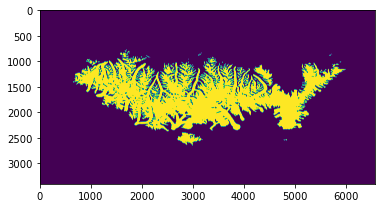

In [5]:
## generate glacier mask
# mask = vec2mask(vec_path=path_glacier_vec, raster_path=path_dem, output_path=rgi_mask_path)
rgi_mask, rgi_mask_info = readTiff(rgi_mask_path)
plt.imshow(rgi_mask)


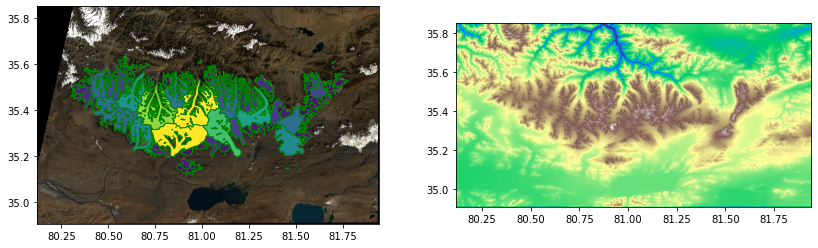

In [6]:
#### show remote sensing image, dem and rgi data
## convert utm coords to wgs84 coords
lon1,lon2,lat1,lat2  = rs_img_info['geoextent']
lon_wgs84, lat_wgs84 = coor2coor(srs_from=rs_img_info['geosrs'], \
                              srs_to=4326, x=[lon1,lon2], y=[lat1,lat2])
extent_wgs84 = lon_wgs84 + lat_wgs84

## show dem/rgi_data
plt.figure(figsize=(14, 4))
ax1 = plt.subplot(1,2,1)
imgShow(rs_img, extent = extent_wgs84, \
                color_bands=(2, 1, 0), clip_percent=5)
geodf_rgi1305.plot('Area', ax=ax1, markersize=1, \
                            edgecolor='green', label='glacier')
ax2 = plt.subplot(1,2,2)
plt.imshow(img_dem, vmax=7000, vmin=4000, \
                        extent=img_dem_info['geoextent'],cmap='terrain')



### Read atl03 data

In [7]:
# !h5ls data/icesat2/processed_atl03/atl03_202001_subs.h5

In [8]:
### atl06 data, one month
with h5py.File('data/icesat2/processed_atl03/atl03_202001_subs.h5','r') as f_a:
    lat_atl03   = f_a['lat'][:]
    lon_atl03   = f_a['lon'][:]
    h_elv_atl03 = f_a['h_elv'][:]
    time_atl03 = f_a['t_year'][:]
    rgt_atl03 = f_a['rgt'][:]
    spot_atl03 = f_a['spot'][:]
    beam_atl03 = f_a['beam_type'][:]   # 1->strong; 0->weak
    print(f_a.keys())
x_atl03, y_atl03 = coor2coor(srs_from=4326, \
                    srs_to=rs_img_info['geosrs'], x=lon_atl03, y=lat_atl03)


<KeysViewHDF5 ['beam_type', 'cycle', 'h_elv', 'lat', 'lon', 'rgt', 'spot', 't_year']>


### Read atl06 data

In [9]:
# !h5ls data/icesat2/processed_atl06/atl06_202001_subs.h5


In [10]:
### atl06 data, one month
with h5py.File('data/icesat2/processed_atl06/atl06_202001_subs.h5','r') as f_a:
    lat_atl06   = f_a['lat'][:]
    lon_atl06   = f_a['lon'][:]
    h_elv_atl06 = f_a['h_elv'][:]
    time_atl06 = f_a['t_year'][:]
    rgt_atl06 = f_a['rgt'][:]
    spot_atl06 = f_a['spot'][:]
    beam_atl06 = f_a['beam_type'][:]
    print(f_a.keys())
x_atl06, y_atl06 = coor2coor(srs_from=4326, \
                    srs_to=rs_img_info['geosrs'], x=lon_atl06, y=lat_atl06)


<KeysViewHDF5 ['beam_type', 'cycle', 'h_elv', 'lat', 'lon', 'quality_summary', 'rgt', 'spot', 't_year']>


### Visualize tracks of atl03 and atl06 data.

In [14]:
print(rgt_atl03)
print(rgt_atl06)
print(spot_atl03)
print(spot_atl06)
print(beam_atl03)
print(beam_atl06)


[142. 142. 142. ... 348. 348. 348.]
[142. 142. 142. ... 348. 348. 348.]
[6. 6. 6. ... 1. 1. 1.]
[6. 6. 6. ... 1. 1. 1.]
[0. 0. 0. ... 1. 1. 1.]
[0. 0. 0. ... 1. 1. 1.]


Text(0.5, 1.0, 'atl06/weak (red) and strong (green) beam')

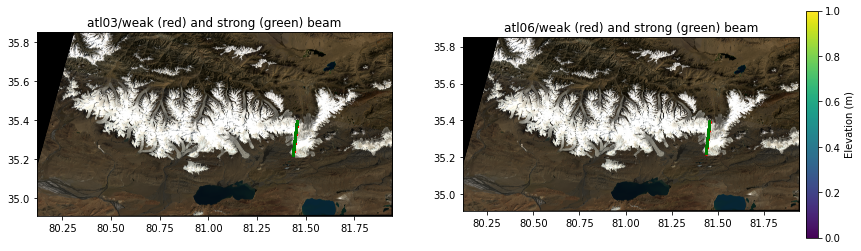

In [31]:
#### weak beam
plt.figure(figsize=(14,5))
### 1. atl03 data
idx_atl03_w = np.where((rgt_atl03==142) & (spot_atl03 == 6))[0]  # weak beam
# idx_atl03_s = np.where((rgt_atl03==142) & (spot_atl03 == 1))[0]  # strong beam
idx_atl03_s = np.where((rgt_atl03==142) & (spot_atl03 == 5))[0]  # strong beam
plt.subplot(1,2,1)
imgShow(rs_img, extent = extent_wgs84, \
                          color_bands=(2, 1, 0), clip_percent=5)
plt.scatter(x=x_atl03[idx_atl03_w], y=y_atl03[idx_atl03_w], \
                          c='r', vmax=7000, vmin=4000, s=1)
plt.scatter(x=x_atl03[idx_atl03_s], y=y_atl03[idx_atl03_s], \
                          c='g', vmax=7000, vmin=4000, s=1)
plt.title('atl03/weak (red) and strong (green) beam')

### 2. atl06 data
idx_atl06_w = np.where((rgt_atl06==142) & (spot_atl06 == 6))[0]
# idx_atl06_s = np.where((rgt_atl06==142) & (spot_atl06 == 1))[0] 
idx_atl06_s = np.where((rgt_atl06==142) & (spot_atl06 == 5))[0]
plt.subplot(1,2,2)
imgShow(rs_img, extent = extent_wgs84, \
                          color_bands=(2, 1, 0), clip_percent=5)
plt.scatter(x=x_atl06[idx_atl06_w], y=y_atl06[idx_atl06_w], \
                          c='r', vmax=7000, vmin=4000, s=1)
plt.scatter(x=x_atl06[idx_atl06_s], y=y_atl06[idx_atl06_s], \
                          c='g', vmax=7000, vmin=4000,s=1)
plt.colorbar(fraction=0.0320, pad=0.02, label='Elevation (m)')
plt.title('atl06/weak (red) and strong (green) beam')


### Atl03 weak beam/strong beam tracks

Text(0.5, 1.0, 'atl03 weak beam (red) and strong beam (green) tracks')

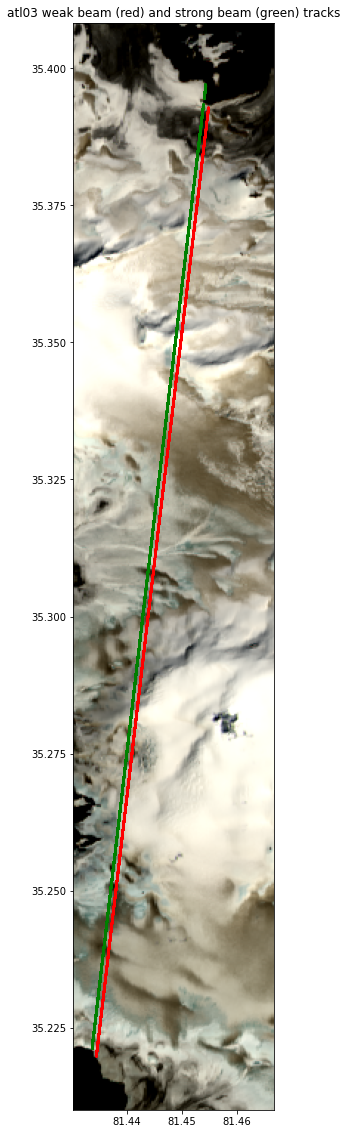

In [123]:
plt.figure(figsize=(10,20))
### 1. atl03 data
plt.subplot(1,2,1)
imgShow(rs_img, extent = extent_wgs84, \
                color_bands=(2, 1, 0), clip_percent=5, focus=[0.47,0.68,0.72,0.74])
plt.scatter(x=x_atl03[idx_atl03_w], y=y_atl03[idx_atl03_w], \
                                c='r', vmax=7000, vmin=4000, s=1)
plt.scatter(x=x_atl03[idx_atl03_s], y=y_atl03[idx_atl03_s], \
                                c='g', vmax=7000, vmin=4000, s=1)
plt.title('atl03 weak beam (red) and strong beam (green) tracks')


### Visualize photons point cloud of atl03 and atl06 data.
#### Weak beam

Text(0.5, 1.0, 'atl03-atl06/strong beam (local)')

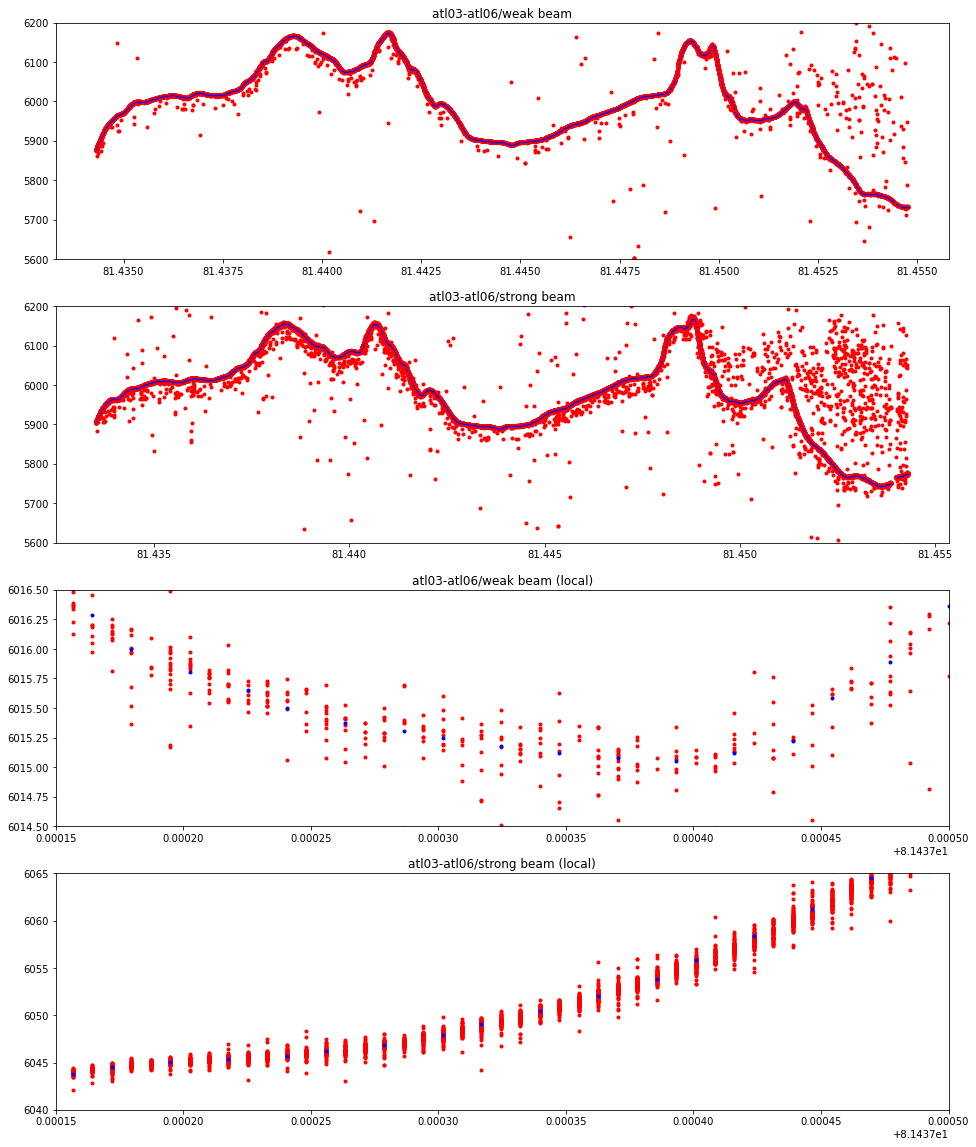

In [112]:
plt.figure(figsize=(16, 20))
### weak beam
plt.subplot(4,1,1)
plt.plot(x_atl03[idx_atl03_w], h_elv_atl03[idx_atl03_w], 'r.')
plt.plot(x_atl06[idx_atl06_w], h_elv_atl06[idx_atl06_w], 'b.',markersize=1)
plt.ylim(5600, 6200)
plt.title('atl03-atl06/weak beam')
### strong beam
plt.subplot(4,1,2)
plt.plot(x_atl03[idx_atl03_s], h_elv_atl03[idx_atl03_s], 'r.')
plt.plot(x_atl06[idx_atl06_s], h_elv_atl06[idx_atl06_s], 'b.',markersize=1)
plt.ylim(5600, 6200)
plt.title('atl03-atl06/strong beam')
#### sub_region
### weak beam
plt.subplot(4,1,3)
plt.plot(x_atl03[idx_atl03_w], h_elv_atl03[idx_atl03_w], 'r.')
plt.plot(x_atl06[idx_atl06_w], h_elv_atl06[idx_atl06_w], 'b.')
plt.xlim(81.43715, 81.4375)
plt.ylim(6014.5, 6016.5)
plt.title('atl03-atl06/weak beam (local)')
### strong beam
plt.subplot(4,1,4)
plt.plot(x_atl03[idx_atl03_s], h_elv_atl03[idx_atl03_s], 'r.')
plt.plot(x_atl06[idx_atl06_s], h_elv_atl06[idx_atl06_s], 'b.')
plt.xlim(81.43715, 81.4375)
plt.ylim(6040, 6065)
plt.title('atl03-atl06/strong beam (local)')

